In [23]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize, LabelEncoder

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

from tqdm.notebook import tqdm
tqdm.pandas()

# Data

Read the dataset

In [25]:
df = pd.read_csv('../Downloads/pivot-study/center-training-data.csv')
print('Shape: ' + str(df.shape))
display(df.head(5))

# NOTE TO SELF: THINK WOULD LIKE TO ADD PREV DAY CLOSE2PIVOT
# MODEL HERE FIRST THEN ITERATE

Shape: (137, 10)


,center2pivot,on2pivot,onrange,open2pivot,or2pivot,orrange,close2pivot,prevval,rthrange,dayofweek
0,-64.083333,-19.583333,54.00,-31.833333,-42.583333,28.50,-6.583333,-3.083333,21.50,Tue
1,-1.958333,-0.333333,33.50,-4.333333,-3.958333,24.75,-88.583333,-64.083333,71.50,Wed
2,-25.375000,12.875000,33.75,6.750000,6.375000,15.75,-5.333333,-1.958333,32.25,Thu
3,-2.041667,-33.291667,60.25,-8.416667,-16.291667,28.25,-56.750000,-25.375000,79.25,Fri
4,-24.000000,8.500000,47.00,4.750000,5.375000,18.25,23.833333,-2.041667,88.75,Mon


### EDA

Distribution of target variable

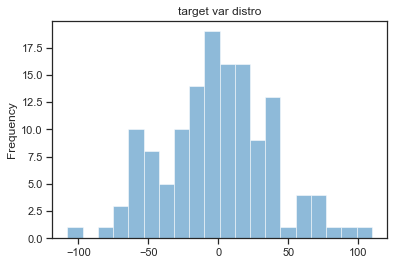

In [26]:
# plot = df.category.value_counts(normalize=True).plot.pie(autopct='%1.0f%%', 
#                                                          figsize=(5, 5), 
#                                                          title='% of News per Topic', 
#                                                          ylabel='')

plot = df.center2pivot.plot.hist(bins=20,
                                alpha=0.5,
                                title='target var distro')

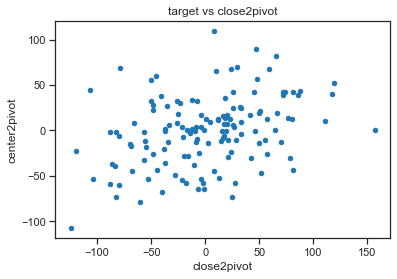

In [28]:
# explore relationship between input variables and the target

invar = 'close2pivot'

plot = df.plot.scatter(x=invar,
                       y='center2pivot',
                       title='target vs '+invar
                       )

## Split Train and Test
Train (80%) and Test (20%). Stratified to maintain the proportion of the labels

In [37]:
invars = df[df.columns[1:9]]

display(invars.head(5))

,on2pivot,onrange,open2pivot,or2pivot,orrange,close2pivot,prevval,rthrange
0,-19.583333,54.00,-31.833333,-42.583333,28.50,-6.583333,-3.083333,21.50
1,-0.333333,33.50,-4.333333,-3.958333,24.75,-88.583333,-64.083333,71.50
2,12.875000,33.75,6.750000,6.375000,15.75,-5.333333,-1.958333,32.25
3,-33.291667,60.25,-8.416667,-16.291667,28.25,-56.750000,-25.375000,79.25
4,8.500000,47.00,4.750000,5.375000,18.25,23.833333,-2.041667,88.75


In [38]:
X = invars
y = df.center2pivot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.19, random_state=9)
print('Shape train: ' + str(X_train.shape))
print('Shape test: ' + str(X_test.shape))

Shape train: (110, 8)
Shape test: (27, 8)


# Modelling

Train 2 different models

## LinearSVC

Train LinearSVC using gridsearch, stratified cross-validation and optimizing the balanced accuracy

In [39]:
param_grid = { 
    'penalty': ['l1', 'l2'],
    'loss' : ['hinge', 'squared_hinge'],
    'C': np.arange(0.1, 1.1, 0.1),
    'class_weight': ['balanced']
}

svc = LinearSVC(random_state=9)
svc_clf = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, # Stratified Kfold by default (cv)
                       scoring='balanced_accuracy', refit=True,
                       return_train_score=False, n_jobs=-1, verbose=1)
svc_clf.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 254, in fit
    check_classification_targets(y)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/multiclass.py", line 197, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Un

ValueError: Unknown label type: 'continuous'

In [18]:
display(pd.DataFrame(svc_clf.cv_results_).sort_values('rank_test_score').head(5))
print('Best score: ' + str(svc_clf.best_score_))
print('Best params: ' + str(svc_clf.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,1.004982,0.021901,0.006448,0.000234,0.3,balanced,squared_hinge,l2,"{'C': 0.30000000000000004, 'class_weight': 'ba...",0.856989,0.854426,0.856773,0.855288,0.855769,0.855849,0.000949,1
7,0.955020,0.034754,0.006556,0.000062,0.2,balanced,squared_hinge,l2,"{'C': 0.2, 'class_weight': 'balanced', 'loss':...",0.857028,0.855577,0.856930,0.854736,0.854703,0.855795,0.001017,2
21,2.203387,0.165129,0.006458,0.000101,0.6,balanced,hinge,l2,"{'C': 0.6, 'class_weight': 'balanced', 'loss':...",0.857163,0.854450,0.855239,0.855664,0.854547,0.855413,0.000983,3
33,2.994942,0.392858,0.006474,0.000145,0.9,balanced,hinge,l2,"{'C': 0.9, 'class_weight': 'balanced', 'loss':...",0.858854,0.854604,0.854129,0.854035,0.855227,0.855370,0.001793,4
29,2.597344,0.158158,0.006732,0.000307,0.8,balanced,hinge,l2,"{'C': 0.8, 'class_weight': 'balanced', 'loss':...",0.858201,0.854604,0.852989,0.855553,0.854429,0.855155,0.001729,5


Best score: 0.8558489996828632
Best params: {'C': 0.30000000000000004, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'}


## Naive Bayes

In [19]:
param_grid = { 
    'alpha': np.arange(0, 1.1, 0.1),
    'fit_prior': [True, False],
}

svc = MultinomialNB()
nb_clf = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, # Stratified Kfold by default (cv)
                      scoring='balanced_accuracy', refit=True,
                      return_train_score=False, n_jobs=-1, verbose=1)
nb_clf.fit(X_train_enc, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'fit_prior': [True, False]},
             scoring='balanced_accuracy', verbose=1)

In [20]:
display(pd.DataFrame(nb_clf.cv_results_).sort_values('rank_test_score').head(5))
print('Best score: ' + str(nb_clf.best_score_))
print('Best params: ' + str(nb_clf.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.026037,0.000397,0.006057,0.000046,0.4,False,"{'alpha': 0.4, 'fit_prior': False}",0.848199,0.841636,0.844795,0.846691,0.845506,0.845365,0.002193,1
11,0.026336,0.000507,0.006029,0.000091,0.5,False,"{'alpha': 0.5, 'fit_prior': False}",0.847387,0.842266,0.845334,0.846505,0.845094,0.845317,0.001735,2
13,0.026321,0.000382,0.006030,0.000063,0.6,False,"{'alpha': 0.6000000000000001, 'fit_prior': False}",0.846469,0.842300,0.845673,0.846643,0.844245,0.845066,0.001622,3
15,0.026021,0.000649,0.005977,0.000095,0.7,False,"{'alpha': 0.7000000000000001, 'fit_prior': False}",0.845894,0.842214,0.844958,0.845852,0.844581,0.844700,0.001343,4
7,0.030194,0.004343,0.006206,0.000386,0.3,False,"{'alpha': 0.30000000000000004, 'fit_prior': Fa...",0.847540,0.840664,0.843935,0.845566,0.844628,0.844467,0.002255,5


Best score: 0.845365331468597
Best params: {'alpha': 0.4, 'fit_prior': False}


# Results

Create the functions to obtain the metrics:
- Accuracy, Balanced accuracy and Report
- Confusion matrix
- Roc curve

In [21]:
def general_metrics(y_test, y_pred):
    print('Accuracy: ' + str(accuracy_score(y_test, y_pred).round(2)))
    print('Balanced Accuracy: ' + str(balanced_accuracy_score(y_test, y_pred).round(2)))
    print('Report:')
    print(classification_report(y_test, y_pred))

def plot_confusion_matrix(y_test, y_pred, classes):
    fig, ax = plt.subplots(figsize=(10, 8))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred),
        display_labels=classes)
    cmp.plot(ax=ax)
    plt.show()
    
def plot_roc_curve(y_test, y_score, classes):
    n_classes = len(classes)
    y_test = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
  
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,5))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
             color="tab:pink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
             label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
             color="tab:gray", linestyle=":", linewidth=4,)

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    for i, color in enumerate(colors):
        type_class = classes[i]
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                 label="ROC curve of " + type_class +" (area = {1:0.2f})".format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()

## LinearSVC Results

In [22]:
y_pred = svc_clf.predict(X_test_enc)
y_score = svc_clf.decision_function(X_test_enc)

general_metrics(y_test, y_pred)

Accuracy: 0.88
Balanced Accuracy: 0.86
Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      3212
           1       0.94      0.91      0.92      6548
           2       0.76      0.79      0.77       977
           3       0.83      0.86      0.84      1977
           4       0.84      0.88      0.86      3565

    accuracy                           0.88     16279
   macro avg       0.85      0.86      0.85     16279
weighted avg       0.88      0.88      0.88     16279



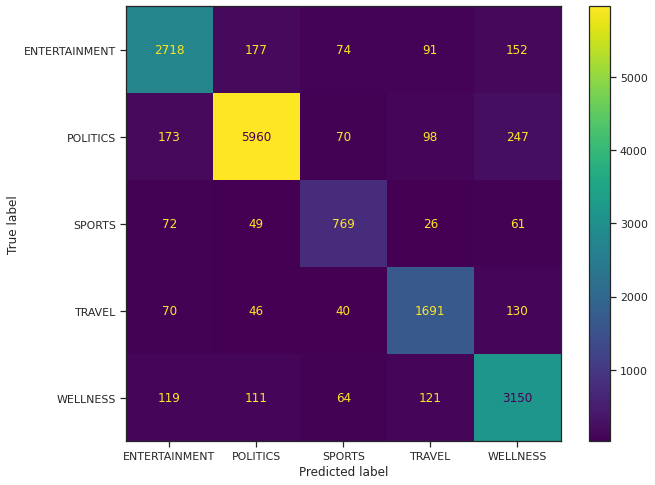

In [23]:
plot_confusion_matrix(y_test, y_pred, classes)

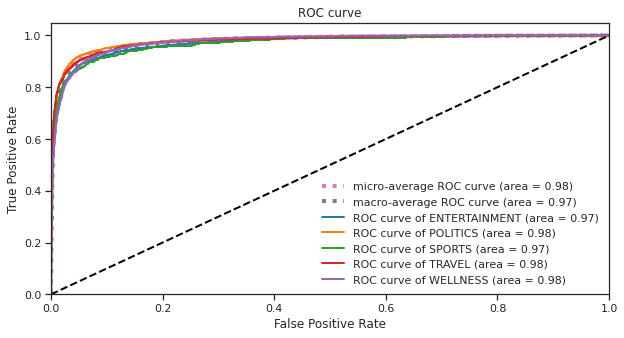

In [24]:
plot_roc_curve(y_test, y_score, classes)

## Naive Bayes Results

In [25]:
y_pred = nb_clf.predict(X_test_enc)
y_score = nb_clf.predict_proba(X_test_enc)

general_metrics(y_test, y_pred)

Accuracy: 0.85
Balanced Accuracy: 0.85
Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3212
           1       0.94      0.88      0.91      6548
           2       0.62      0.83      0.71       977
           3       0.77      0.86      0.82      1977
           4       0.87      0.82      0.85      3565

    accuracy                           0.85     16279
   macro avg       0.81      0.85      0.82     16279
weighted avg       0.86      0.85      0.86     16279



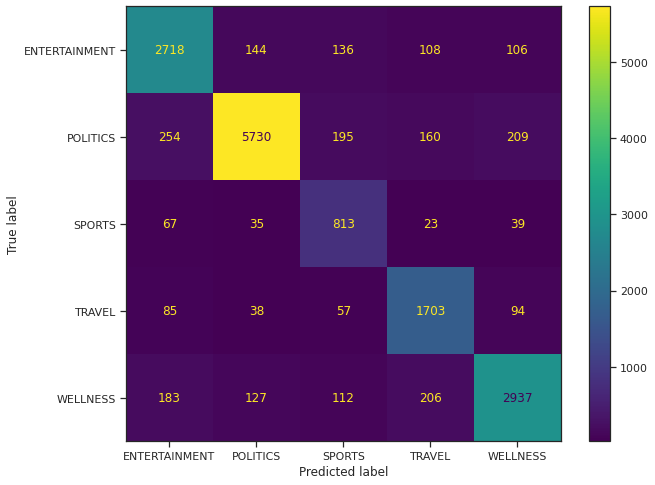

In [26]:
plot_confusion_matrix(y_test, y_pred, classes)

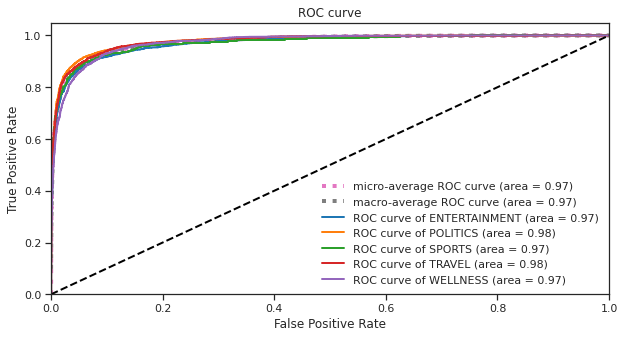

In [27]:
plot_roc_curve(y_test, y_score, classes)

# Demo

In [28]:
def get_random_new(news_df, classes, topic):
    sample = news_df[test_og['category'] == classes.index(topic)].sample(1).iloc[0]
    text = sample['headline']
    label = sample['category']
    return text, label

def deliver_new(new, normalizer, encoder, model, users, classes):
    print('Headline: ' + new)
    #print('True label: ' + classes[new[1]])
    
    new_norm = normalizer.clean_all(new)
    new_enc = encoder.transform([new_norm])
    idx_class = model.predict(new_enc)[0]
    class_ = classes[idx_class]
    
    print('Classify as: ' + class_)
    print('Delivered to the following users: ', end='')
    final_users = []
    for k,v in users.get_items():
        if class_ in v:
            final_users.append(k)
    print(final_users)

Generate 10 random users for the demo

In [29]:
users = Users(10, classes)
users.users

{'user_1': ['WELLNESS'],
 'user_2': ['SPORTS', 'WELLNESS', 'TRAVEL', 'ENTERTAINMENT'],
 'user_3': ['WELLNESS', 'TRAVEL', 'SPORTS', 'ENTERTAINMENT'],
 'user_4': ['SPORTS', 'WELLNESS'],
 'user_5': ['WELLNESS', 'POLITICS'],
 'user_6': ['WELLNESS', 'POLITICS'],
 'user_7': ['ENTERTAINMENT', 'POLITICS', 'SPORTS', 'WELLNESS'],
 'user_8': ['ENTERTAINMENT', 'POLITICS', 'TRAVEL'],
 'user_9': ['POLITICS', 'SPORTS', 'WELLNESS'],
 'user_10': ['WELLNESS', 'SPORTS', 'TRAVEL']}

Retrieve the original test set headlines

In [30]:
test_og = df.loc[y_test.index]

Example by distributing a random POLITICS news item from test

In [31]:
new, label = get_random_new(test_og, classes, 'POLITICS')
deliver_new(new, norm, tfidf, svc_clf, users, classes)

Headline: Can Joe Biden Save the Democrats? (and Do the Dems Need Saving?)
Classify as: POLITICS
Delivered to the following users: ['user_5', 'user_6', 'user_7', 'user_8', 'user_9']


Example by distributing an inputed headline.

In [32]:
new = 'The Man at the Center of the French Election Isn’t Even on the Ballot'
deliver_new(new, norm, tfidf, svc_clf, users, classes)

Headline: The Man at the Center of the French Election Isn’t Even on the Ballot
Classify as: POLITICS
Delivered to the following users: ['user_5', 'user_6', 'user_7', 'user_8', 'user_9']
